In [19]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import momepy

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [4]:
gdf = gpd.read_file('/media/aaron/Extreme SSD/Atlas_Source/North_American_Roads.shp')

In [5]:
gdf = gdf.to_crs(4326)

In [6]:
gdf_us = gdf[gdf['COUNTRY'] == 2]

In [49]:
for state in states:

    os.mkdir('Outputs/' + state.replace(' ', '_'))

In [10]:
states = np.array([s[3:] for s in gdf_us['JURISCODE'].unique()])
states

array(['02', '06', '15', '23', '05', '40', '48', '31', '46', '38', '28',
       '29', '20', '17', '01', '13', '45', '37', '12', '22', '08', '04',
       '35', '30', '53', '32', '16', '41', '49', '56', '47', '39', '26',
       '18', '21', '51', '19', '55', '42', '27', '25', '33', '09', '36',
       '44', '34', '50', '10', '24', '54', '11'], dtype='<U2')

In [11]:
states = np.array([s[3:] for s in gdf_us['JURISCODE'].unique()])

node_attributes = {}

link_attributes = {
    "distance": "lambda e: e['LENGTH']*1e3",
    "speed": "lambda e: e['SPEEDLIM']/3.6",
    "time": "lambda e: (e['LENGTH']*1e3)/(e['SPEEDLIM']/3.6)",
    "number": "lambda e: e['ROADNUM']"
}

for state in src.progress_bar.ProgressBar(states):

    path = 'Outputs/' + state + '/'

    if not os.path.exists(path):

        os.mkdir(path)

    gdf_state = gdf_us[gdf_us['JURISCODE'] == '02_' + state]

    g = src.graph.graph_from_gdf(gdf_state.explode())

    g = src.graph.reformat_graph(
        g, node_attributes, link_attributes,
    )

    src.graph.graph_to_json(g, path + 'atlas.json')

 [----------->] (51/51) 100.00%, 0.30 it/s, 173.42 s elapsed, 0.00 s remaining

In [28]:
'''
Reducing road map density
'''
deep_reload(src)

states = list(src.fips.fips_to_name.keys())

for state in src.progress_bar.ProgressBar(states):

    path = 'Outputs/' + state.replace(' ', '_') + '/'

    g = src.graph.graph_from_json(path + 'atlas.json')

    rg = src.adjacency.reduction(g, maximum_cost = 50000)

    src.graph.graph_to_json(rg, path + 'reduced_atlas.json')

 [----------->] (51/51) 100.00%, 0.50 it/s, 103.75 s elapsed, 0.00 s remaining

In [33]:
graphs = {
    s: src.graph.graph_from_json('Outputs/' + s + '/reduced_atlas.json') for s in states
}

for s, graph in graphs.items():

    for source, node in graph._node.items():

        node['state'] = s

In [35]:
deep_reload(src)

continental = (
    [k for k, v in src.fips.fips_to_name.items() if v not in ['ALASKA', 'HAWAII']]
)

supergraph = src.graph.supergraph([v for k, v in graphs.items() if k in continental])

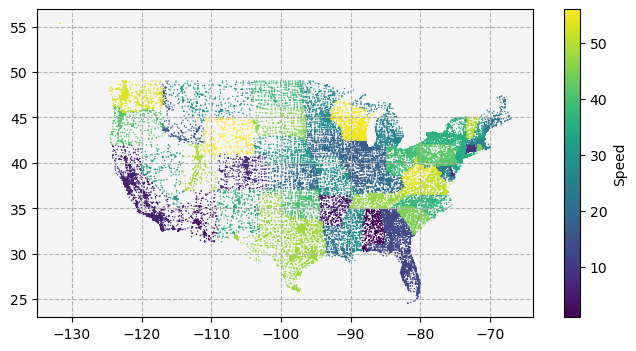

In [39]:
deep_reload(src)

for source, node in supergraph._node.items():

    node['plot'] = int(node['state'])

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

kw = {
    'show_nodes': True,
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 1,
        'ec': 'none',
        'zorder': 0,
    },
    'plot': {
        'color': 'k',
        'lw': .5,
    },
    'colorbar': {
        'label': 'Speed',
    },
}

src.figures.plot_graph(supergraph, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

In [37]:
supergraph.number_of_nodes(), supergraph.number_of_edges()

(63386, 100637)

In [38]:
src.graph.graph_to_json(supergraph, 'Outputs/reduced_atlas.json')

In [76]:
graph = src.graph.graph_from_gdf(gdf_us.explode())

In [78]:
node_attributes = {
}

link_attributes = {
    "length": "lambda e: e['LENGTH']*1e3",
    "speed": "lambda e: e['SPEEDLIM']/3.6",
    "time": "lambda e: (e['LENGTH']*1e3)/(e['SPEEDLIM']/3.6)",
    "number": "lambda e: e['ROADNUM']",
    "state": "lambda e: int(e['JURISCODE'][3:])",
}

graph = src.graph.reformat_graph(
    graph, node_attributes, link_attributes,
)

In [82]:
src.graph.graph_to_json(graph, 'Outputs/atlas.json')

In [84]:
for source, adj in graph._adj.items():

    states = []
    
    for target, edge in adj.items():

        states.append(edge['state'])

        break

    graph._node[source]["state"] = states[0]

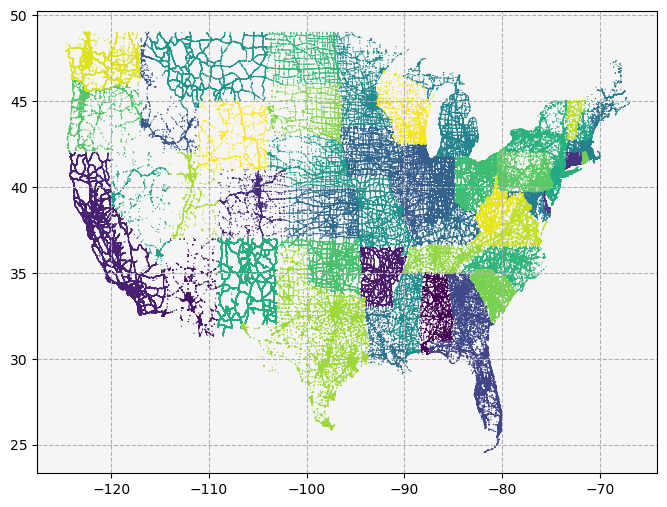

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

kw = {
    'show_links': False,
    'node_field': 'state',
    'scatter': {
        's': .75,
        'ec': 'none',
        # 'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)